In [1]:
import scvi
# import scib

import scanpy as sc
import pandas as pd
import numpy as np

Global seed set to 0


In [2]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))

In [3]:
url = "https://figshare.com/ndownloader/files/24539828"
adata = sc.read("pancreas.h5ad", backup_url=url)
print(adata)

AnnData object with n_obs × n_vars = 16382 × 19093
    obs: 'tech', 'celltype', 'size_factors'
    layers: 'counts'


In [4]:
adata.obs.tech.value_counts()

inDrop3       3605
smartseq2     2394
celseq2       2285
inDrop1       1937
inDrop2       1724
smarter       1492
inDrop4       1303
celseq        1004
fluidigmc1     638
Name: tech, dtype: int64

In [5]:
query = np.array([s in ["smartseq2", "celseq2"] for s in adata.obs.tech])

adata_ref = adata[~query].copy()
adata_query = adata[query].copy()

In [6]:
sc.pp.highly_variable_genes(
    adata_ref,
    n_top_genes=2000,
    batch_key="tech",
    subset=True
)

adata_query = adata_query[:, adata_ref.var_names].copy()

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/

In [7]:
scvi.model.SCVI.setup_anndata(adata_ref, batch_key="tech", layer="counts")

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/data/fields/_layer_field.py:78: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(


In [8]:
arches_params = dict(
    use_layer_norm="both",
    use_batch_norm="none",
    encode_covariates=True,
    dropout_rate=0.2,
    n_layers=2,
)

# vae_ref = scvi.model.SCVI(
#     adata_ref,
#     **arches_params
# )
# vae_ref.train()

In [9]:
dir_path = "../../notebooks/pancreas_model/"
# vae_ref.save(dir_path, overwrite=True)

In [10]:
vae_ref = scvi.model.SCVI.load(dir_path, adata_ref)

INFO     File ../../notebooks/pancreas_model/model.pt already downloaded                     


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/data/fields/_layer_field.py:78: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(


In [11]:
vae_ref

SCVI Model with the following params: 
n_hidden: 128, n_latent: 10, n_layers: 2, dropout_rate: 0.2, dispersion: gene, 
gene_likelihood: zinb, latent_distribution: normal
Training status: Trained

In [12]:
vae_ref.summary_stats

attrdict({'n_cells': 11703, 'n_vars': 2000, 'n_batch': 7, 'n_labels': 1, 'n_extra_categorical_covs': 0, 'n_extra_continuous_covs': 0})

In [13]:
adata_ref.obsm["X_scVI"] = vae_ref.get_latent_representation(adata_ref)
sc.pp.neighbors(adata_ref, use_rep="X_scVI")
# sc.tl.leiden(adata_full)
sc.tl.umap(adata_ref)

OMP: Info #273: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


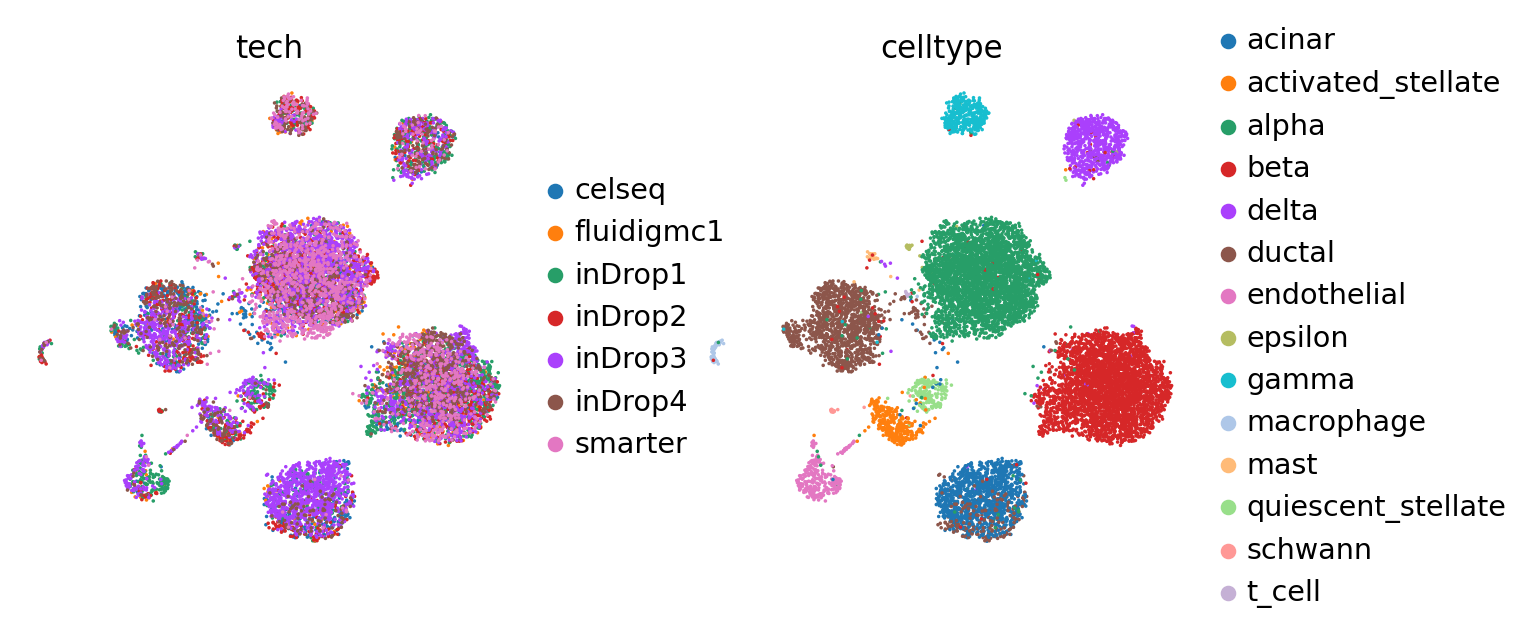

In [14]:
sc.pl.umap(
    adata_ref,
    color=["tech", "celltype"],
    frameon=False,
    ncols=2,
#     save = 'pancreas_scvi.png'
)

In [15]:
scvi.model.SCVI.setup_anndata(adata_query, batch_key="tech", layer="counts")

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/data/fields/_layer_field.py:78: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(


In [16]:
vae_q = scvi.model.SCVI.load_query_data(
    adata_query,
    dir_path,

)

INFO     File ../../notebooks/pancreas_model/model.pt already downloaded                     


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/data/fields/_layer_field.py:78: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(


In [17]:
vae_q.train(max_epochs=200, plan_kwargs=dict(weight_decay=0.0))

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Epoch 1/200:   0%|          | 0/200 [00:00<?, ?it/s]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 2/200:   0%|          | 1/200 [00:00<01:14,  2.65it/s, loss=1.92e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 3/200:   1%|          | 2/200 [00:00<01:02,  3.18it/s, loss=1.89e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 4/200:   2%|▏         | 3/200 [00:00<00:58,  3.38it/s, loss=1.86e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 5/200:   2%|▏         | 4/200 [00:01<00:59,  3.29it/s, loss=1.86e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 6/200:   2%|▎         | 5/200 [00:01<00:57,  3.39it/s, loss=1.84e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 7/200:   3%|▎         | 6/200 [00:01<00:57,  3.38it/s, loss=1.84e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 8/200:   4%|▎         | 7/200 [00:02<00:56,  3.39it/s, loss=1.83e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 9/200:   4%|▍         | 8/200 [00:02<00:57,  3.37it/s, loss=1.81e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 10/200:   4%|▍         | 9/200 [00:02<00:56,  3.35it/s, loss=1.81e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 11/200:   5%|▌         | 10/200 [00:03<00:56,  3.34it/s, loss=1.82e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 12/200:   6%|▌         | 11/200 [00:03<00:55,  3.39it/s, loss=1.83e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 13/200:   6%|▌         | 12/200 [00:03<00:52,  3.58it/s, loss=1.79e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 14/200:   6%|▋         | 13/200 [00:03<00:53,  3.48it/s, loss=1.81e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 15/200:   7%|▋         | 14/200 [00:04<00:52,  3.53it/s, loss=1.79e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 16/200:   8%|▊         | 15/200 [00:04<00:51,  3.61it/s, loss=1.78e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 17/200:   8%|▊         | 16/200 [00:04<00:50,  3.64it/s, loss=1.79e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 18/200:   8%|▊         | 17/200 [00:04<00:49,  3.69it/s, loss=1.8e+03, v_num=1] 

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 19/200:   9%|▉         | 18/200 [00:05<00:49,  3.68it/s, loss=1.8e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 20/200:  10%|▉         | 19/200 [00:05<00:48,  3.71it/s, loss=1.79e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 21/200:  10%|█         | 20/200 [00:05<00:48,  3.75it/s, loss=1.78e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 22/200:  10%|█         | 21/200 [00:05<00:47,  3.78it/s, loss=1.78e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 23/200:  11%|█         | 22/200 [00:06<00:47,  3.76it/s, loss=1.8e+03, v_num=1] 

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 24/200:  12%|█▏        | 23/200 [00:06<00:46,  3.79it/s, loss=1.79e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 25/200:  12%|█▏        | 24/200 [00:06<00:46,  3.79it/s, loss=1.8e+03, v_num=1] 

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 26/200:  12%|█▎        | 25/200 [00:07<00:46,  3.79it/s, loss=1.75e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 27/200:  13%|█▎        | 26/200 [00:07<00:46,  3.77it/s, loss=1.77e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 28/200:  14%|█▎        | 27/200 [00:07<00:46,  3.74it/s, loss=1.78e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 29/200:  14%|█▍        | 28/200 [00:07<00:46,  3.72it/s, loss=1.77e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 30/200:  14%|█▍        | 29/200 [00:08<00:46,  3.72it/s, loss=1.79e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 31/200:  15%|█▌        | 30/200 [00:08<00:45,  3.73it/s, loss=1.79e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 32/200:  16%|█▌        | 31/200 [00:08<00:44,  3.76it/s, loss=1.76e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 33/200:  16%|█▌        | 32/200 [00:08<00:44,  3.77it/s, loss=1.78e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 34/200:  16%|█▋        | 33/200 [00:09<00:44,  3.78it/s, loss=1.78e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 35/200:  17%|█▋        | 34/200 [00:09<00:43,  3.78it/s, loss=1.78e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 36/200:  18%|█▊        | 35/200 [00:09<00:43,  3.82it/s, loss=1.76e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 37/200:  18%|█▊        | 36/200 [00:09<00:42,  3.81it/s, loss=1.77e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 38/200:  18%|█▊        | 37/200 [00:10<00:42,  3.80it/s, loss=1.76e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 39/200:  19%|█▉        | 38/200 [00:10<00:42,  3.79it/s, loss=1.77e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 40/200:  20%|█▉        | 39/200 [00:10<00:42,  3.77it/s, loss=1.76e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 41/200:  20%|██        | 40/200 [00:11<00:42,  3.76it/s, loss=1.77e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 42/200:  20%|██        | 41/200 [00:11<00:42,  3.78it/s, loss=1.76e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 43/200:  21%|██        | 42/200 [00:11<00:41,  3.81it/s, loss=1.75e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 44/200:  22%|██▏       | 43/200 [00:11<00:41,  3.79it/s, loss=1.75e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 45/200:  22%|██▏       | 44/200 [00:12<00:40,  3.81it/s, loss=1.76e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 46/200:  22%|██▎       | 45/200 [00:12<00:40,  3.83it/s, loss=1.76e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 47/200:  23%|██▎       | 46/200 [00:12<00:40,  3.82it/s, loss=1.76e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 48/200:  24%|██▎       | 47/200 [00:12<00:39,  3.83it/s, loss=1.77e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 49/200:  24%|██▍       | 48/200 [00:13<00:39,  3.82it/s, loss=1.74e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 50/200:  24%|██▍       | 49/200 [00:13<00:39,  3.83it/s, loss=1.76e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 51/200:  25%|██▌       | 50/200 [00:13<00:39,  3.83it/s, loss=1.75e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 52/200:  26%|██▌       | 51/200 [00:13<00:38,  3.83it/s, loss=1.76e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 53/200:  26%|██▌       | 52/200 [00:14<00:38,  3.83it/s, loss=1.75e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 54/200:  26%|██▋       | 53/200 [00:14<00:38,  3.84it/s, loss=1.75e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 55/200:  27%|██▋       | 54/200 [00:14<00:37,  3.84it/s, loss=1.76e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 56/200:  28%|██▊       | 55/200 [00:14<00:37,  3.83it/s, loss=1.76e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 57/200:  28%|██▊       | 56/200 [00:15<00:37,  3.84it/s, loss=1.76e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 58/200:  28%|██▊       | 57/200 [00:15<00:37,  3.86it/s, loss=1.75e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 59/200:  29%|██▉       | 58/200 [00:15<00:36,  3.84it/s, loss=1.75e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 60/200:  30%|██▉       | 59/200 [00:15<00:36,  3.85it/s, loss=1.76e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 61/200:  30%|███       | 60/200 [00:16<00:35,  3.92it/s, loss=1.75e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 62/200:  30%|███       | 61/200 [00:16<00:35,  3.96it/s, loss=1.76e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 63/200:  31%|███       | 62/200 [00:16<00:34,  3.99it/s, loss=1.78e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 64/200:  32%|███▏      | 63/200 [00:16<00:34,  4.01it/s, loss=1.77e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 65/200:  32%|███▏      | 64/200 [00:17<00:35,  3.86it/s, loss=1.74e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 66/200:  32%|███▎      | 65/200 [00:17<00:36,  3.70it/s, loss=1.77e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 67/200:  33%|███▎      | 66/200 [00:17<00:37,  3.61it/s, loss=1.77e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 68/200:  34%|███▎      | 67/200 [00:18<00:36,  3.68it/s, loss=1.77e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 69/200:  34%|███▍      | 68/200 [00:18<00:35,  3.76it/s, loss=1.76e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 70/200:  34%|███▍      | 69/200 [00:18<00:34,  3.83it/s, loss=1.75e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 71/200:  35%|███▌      | 70/200 [00:18<00:33,  3.87it/s, loss=1.74e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 72/200:  36%|███▌      | 71/200 [00:19<00:32,  3.92it/s, loss=1.75e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 73/200:  36%|███▌      | 72/200 [00:19<00:32,  3.90it/s, loss=1.76e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 74/200:  36%|███▋      | 73/200 [00:19<00:32,  3.90it/s, loss=1.75e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 75/200:  37%|███▋      | 74/200 [00:19<00:32,  3.89it/s, loss=1.76e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 76/200:  38%|███▊      | 75/200 [00:20<00:32,  3.89it/s, loss=1.78e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 77/200:  38%|███▊      | 76/200 [00:20<00:31,  3.91it/s, loss=1.75e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 78/200:  38%|███▊      | 77/200 [00:20<00:31,  3.91it/s, loss=1.76e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 79/200:  39%|███▉      | 78/200 [00:20<00:30,  3.97it/s, loss=1.76e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 80/200:  40%|███▉      | 79/200 [00:21<00:30,  4.01it/s, loss=1.76e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 81/200:  40%|████      | 80/200 [00:21<00:29,  4.03it/s, loss=1.76e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 82/200:  40%|████      | 81/200 [00:21<00:29,  4.06it/s, loss=1.75e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 83/200:  41%|████      | 82/200 [00:21<00:28,  4.08it/s, loss=1.77e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 84/200:  42%|████▏     | 83/200 [00:22<00:30,  3.83it/s, loss=1.73e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 85/200:  42%|████▏     | 84/200 [00:22<00:31,  3.74it/s, loss=1.76e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 86/200:  42%|████▎     | 85/200 [00:22<00:30,  3.73it/s, loss=1.75e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 87/200:  43%|████▎     | 86/200 [00:22<00:30,  3.74it/s, loss=1.75e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 88/200:  44%|████▎     | 87/200 [00:23<00:30,  3.74it/s, loss=1.76e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 89/200:  44%|████▍     | 88/200 [00:23<00:29,  3.76it/s, loss=1.75e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 90/200:  44%|████▍     | 89/200 [00:23<00:29,  3.78it/s, loss=1.77e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 91/200:  45%|████▌     | 90/200 [00:24<00:29,  3.79it/s, loss=1.75e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 92/200:  46%|████▌     | 91/200 [00:24<00:28,  3.81it/s, loss=1.76e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 93/200:  46%|████▌     | 92/200 [00:24<00:28,  3.79it/s, loss=1.75e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 94/200:  46%|████▋     | 93/200 [00:24<00:28,  3.81it/s, loss=1.76e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 95/200:  47%|████▋     | 94/200 [00:25<00:27,  3.79it/s, loss=1.75e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 96/200:  48%|████▊     | 95/200 [00:25<00:27,  3.80it/s, loss=1.77e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 97/200:  48%|████▊     | 96/200 [00:25<00:27,  3.80it/s, loss=1.74e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 98/200:  48%|████▊     | 97/200 [00:25<00:27,  3.78it/s, loss=1.75e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 99/200:  49%|████▉     | 98/200 [00:26<00:26,  3.78it/s, loss=1.74e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 100/200:  50%|████▉     | 99/200 [00:26<00:26,  3.76it/s, loss=1.75e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 101/200:  50%|█████     | 100/200 [00:26<00:27,  3.69it/s, loss=1.75e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 102/200:  50%|█████     | 101/200 [00:26<00:26,  3.75it/s, loss=1.76e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 103/200:  51%|█████     | 102/200 [00:27<00:26,  3.74it/s, loss=1.76e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 104/200:  52%|█████▏    | 103/200 [00:27<00:25,  3.76it/s, loss=1.75e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 105/200:  52%|█████▏    | 104/200 [00:27<00:25,  3.76it/s, loss=1.76e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 106/200:  52%|█████▎    | 105/200 [00:27<00:25,  3.75it/s, loss=1.75e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 107/200:  53%|█████▎    | 106/200 [00:28<00:24,  3.77it/s, loss=1.75e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 108/200:  54%|█████▎    | 107/200 [00:28<00:24,  3.76it/s, loss=1.75e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 109/200:  54%|█████▍    | 108/200 [00:28<00:24,  3.78it/s, loss=1.75e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 110/200:  55%|█████▍    | 109/200 [00:29<00:24,  3.76it/s, loss=1.75e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 111/200:  55%|█████▌    | 110/200 [00:29<00:23,  3.76it/s, loss=1.76e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 112/200:  56%|█████▌    | 111/200 [00:29<00:23,  3.78it/s, loss=1.75e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 113/200:  56%|█████▌    | 112/200 [00:29<00:23,  3.77it/s, loss=1.76e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 114/200:  56%|█████▋    | 113/200 [00:30<00:22,  3.80it/s, loss=1.75e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 115/200:  57%|█████▋    | 114/200 [00:30<00:22,  3.80it/s, loss=1.76e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 116/200:  57%|█████▊    | 115/200 [00:30<00:22,  3.78it/s, loss=1.74e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 117/200:  58%|█████▊    | 116/200 [00:30<00:22,  3.75it/s, loss=1.76e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 118/200:  58%|█████▊    | 117/200 [00:31<00:22,  3.74it/s, loss=1.76e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 119/200:  59%|█████▉    | 118/200 [00:31<00:21,  3.75it/s, loss=1.77e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 120/200:  60%|█████▉    | 119/200 [00:31<00:21,  3.81it/s, loss=1.75e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 121/200:  60%|██████    | 120/200 [00:31<00:20,  3.84it/s, loss=1.76e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 122/200:  60%|██████    | 121/200 [00:32<00:20,  3.87it/s, loss=1.77e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 123/200:  61%|██████    | 122/200 [00:32<00:20,  3.88it/s, loss=1.75e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 124/200:  62%|██████▏   | 123/200 [00:32<00:19,  3.93it/s, loss=1.76e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 125/200:  62%|██████▏   | 124/200 [00:32<00:19,  3.97it/s, loss=1.74e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 126/200:  62%|██████▎   | 125/200 [00:33<00:18,  3.96it/s, loss=1.75e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 127/200:  63%|██████▎   | 126/200 [00:33<00:18,  3.93it/s, loss=1.75e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 128/200:  64%|██████▎   | 127/200 [00:33<00:18,  3.93it/s, loss=1.74e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 129/200:  64%|██████▍   | 128/200 [00:33<00:18,  3.95it/s, loss=1.75e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 130/200:  64%|██████▍   | 129/200 [00:34<00:18,  3.94it/s, loss=1.75e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 131/200:  65%|██████▌   | 130/200 [00:34<00:17,  3.98it/s, loss=1.74e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 132/200:  66%|██████▌   | 131/200 [00:34<00:17,  3.98it/s, loss=1.75e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 133/200:  66%|██████▌   | 132/200 [00:34<00:17,  3.98it/s, loss=1.75e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 134/200:  66%|██████▋   | 133/200 [00:35<00:16,  4.00it/s, loss=1.76e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 135/200:  67%|██████▋   | 134/200 [00:35<00:16,  3.99it/s, loss=1.76e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 136/200:  68%|██████▊   | 135/200 [00:35<00:16,  3.99it/s, loss=1.75e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 137/200:  68%|██████▊   | 136/200 [00:35<00:16,  3.99it/s, loss=1.75e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 138/200:  68%|██████▊   | 137/200 [00:36<00:15,  3.97it/s, loss=1.75e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 139/200:  69%|██████▉   | 138/200 [00:36<00:15,  4.00it/s, loss=1.77e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 140/200:  70%|██████▉   | 139/200 [00:36<00:15,  3.99it/s, loss=1.74e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 141/200:  70%|███████   | 140/200 [00:36<00:15,  3.98it/s, loss=1.73e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 142/200:  70%|███████   | 141/200 [00:37<00:14,  3.99it/s, loss=1.74e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 143/200:  71%|███████   | 142/200 [00:37<00:14,  3.97it/s, loss=1.75e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 144/200:  72%|███████▏  | 143/200 [00:37<00:14,  4.00it/s, loss=1.76e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 145/200:  72%|███████▏  | 144/200 [00:37<00:14,  3.99it/s, loss=1.75e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 146/200:  72%|███████▎  | 145/200 [00:38<00:13,  4.01it/s, loss=1.74e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 147/200:  73%|███████▎  | 146/200 [00:38<00:13,  3.97it/s, loss=1.75e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 148/200:  74%|███████▎  | 147/200 [00:38<00:13,  3.97it/s, loss=1.75e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 149/200:  74%|███████▍  | 148/200 [00:38<00:13,  3.99it/s, loss=1.76e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 150/200:  74%|███████▍  | 149/200 [00:39<00:12,  3.97it/s, loss=1.75e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 151/200:  75%|███████▌  | 150/200 [00:39<00:12,  3.95it/s, loss=1.76e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 152/200:  76%|███████▌  | 151/200 [00:39<00:12,  3.96it/s, loss=1.76e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 153/200:  76%|███████▌  | 152/200 [00:39<00:12,  3.98it/s, loss=1.73e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 154/200:  76%|███████▋  | 153/200 [00:40<00:11,  3.97it/s, loss=1.76e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 155/200:  77%|███████▋  | 154/200 [00:40<00:11,  3.96it/s, loss=1.75e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 156/200:  78%|███████▊  | 155/200 [00:40<00:11,  3.96it/s, loss=1.75e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 157/200:  78%|███████▊  | 156/200 [00:41<00:11,  3.95it/s, loss=1.75e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 158/200:  78%|███████▊  | 157/200 [00:41<00:10,  3.94it/s, loss=1.74e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 159/200:  79%|███████▉  | 158/200 [00:41<00:10,  3.96it/s, loss=1.75e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 160/200:  80%|███████▉  | 159/200 [00:41<00:10,  3.99it/s, loss=1.76e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 161/200:  80%|████████  | 160/200 [00:42<00:10,  3.97it/s, loss=1.74e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 162/200:  80%|████████  | 161/200 [00:42<00:09,  3.93it/s, loss=1.76e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 163/200:  81%|████████  | 162/200 [00:42<00:09,  3.96it/s, loss=1.75e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 164/200:  82%|████████▏ | 163/200 [00:42<00:09,  3.96it/s, loss=1.75e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 165/200:  82%|████████▏ | 164/200 [00:43<00:09,  3.95it/s, loss=1.74e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 166/200:  82%|████████▎ | 165/200 [00:43<00:08,  3.94it/s, loss=1.74e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 167/200:  83%|████████▎ | 166/200 [00:43<00:08,  3.96it/s, loss=1.77e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 168/200:  84%|████████▎ | 167/200 [00:43<00:08,  3.97it/s, loss=1.74e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 169/200:  84%|████████▍ | 168/200 [00:44<00:08,  3.93it/s, loss=1.75e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 170/200:  84%|████████▍ | 169/200 [00:44<00:07,  3.91it/s, loss=1.76e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 171/200:  85%|████████▌ | 170/200 [00:44<00:07,  3.92it/s, loss=1.74e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 172/200:  86%|████████▌ | 171/200 [00:44<00:07,  3.94it/s, loss=1.76e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 173/200:  86%|████████▌ | 172/200 [00:45<00:07,  3.94it/s, loss=1.74e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 174/200:  86%|████████▋ | 173/200 [00:45<00:06,  3.95it/s, loss=1.74e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 175/200:  87%|████████▋ | 174/200 [00:45<00:06,  3.91it/s, loss=1.76e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 176/200:  88%|████████▊ | 175/200 [00:45<00:06,  3.92it/s, loss=1.76e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 177/200:  88%|████████▊ | 176/200 [00:46<00:06,  3.90it/s, loss=1.76e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 178/200:  88%|████████▊ | 177/200 [00:46<00:05,  3.89it/s, loss=1.73e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 179/200:  89%|████████▉ | 178/200 [00:46<00:05,  3.89it/s, loss=1.78e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 180/200:  90%|████████▉ | 179/200 [00:46<00:05,  3.89it/s, loss=1.76e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 181/200:  90%|█████████ | 180/200 [00:47<00:05,  3.93it/s, loss=1.77e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 182/200:  90%|█████████ | 181/200 [00:47<00:04,  3.94it/s, loss=1.75e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 183/200:  91%|█████████ | 182/200 [00:47<00:04,  3.96it/s, loss=1.76e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 184/200:  92%|█████████▏| 183/200 [00:47<00:04,  3.96it/s, loss=1.77e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 185/200:  92%|█████████▏| 184/200 [00:48<00:04,  3.98it/s, loss=1.76e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 186/200:  92%|█████████▎| 185/200 [00:48<00:03,  3.99it/s, loss=1.74e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 187/200:  93%|█████████▎| 186/200 [00:48<00:03,  3.95it/s, loss=1.75e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 188/200:  94%|█████████▎| 187/200 [00:48<00:03,  3.78it/s, loss=1.74e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 189/200:  94%|█████████▍| 188/200 [00:49<00:03,  3.73it/s, loss=1.75e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 190/200:  94%|█████████▍| 189/200 [00:49<00:02,  3.82it/s, loss=1.75e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 191/200:  95%|█████████▌| 190/200 [00:49<00:02,  3.88it/s, loss=1.77e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 192/200:  96%|█████████▌| 191/200 [00:49<00:02,  3.68it/s, loss=1.75e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 193/200:  96%|█████████▌| 192/200 [00:50<00:02,  3.68it/s, loss=1.74e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 194/200:  96%|█████████▋| 193/200 [00:50<00:01,  3.68it/s, loss=1.77e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 195/200:  97%|█████████▋| 194/200 [00:50<00:01,  3.68it/s, loss=1.74e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 196/200:  98%|█████████▊| 195/200 [00:51<00:01,  3.72it/s, loss=1.76e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 197/200:  98%|█████████▊| 196/200 [00:51<00:01,  3.75it/s, loss=1.75e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 198/200:  98%|█████████▊| 197/200 [00:51<00:00,  3.77it/s, loss=1.72e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 199/200:  99%|█████████▉| 198/200 [00:51<00:00,  3.77it/s, loss=1.76e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 200/200: 100%|█████████▉| 199/200 [00:52<00:00,  3.81it/s, loss=1.78e+03, v_num=1]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 200/200: 100%|██████████| 200/200 [00:52<00:00,  3.82it/s, loss=1.76e+03, v_num=1]


In [18]:
vae_q.save('pancreas_surgery')

In [19]:
adata_ = adata_ref.copy()
adata_.obs['tech_orig'] = adata_ref.obs.tech
# adata_.obs.tech = "celseq2"

In [20]:
adata_query.obs["source"] = "query"
adata_query.obs["tech_orig"] = adata_query.obs.tech

In [21]:
adata_full = adata_query.concatenate(adata_)
adata_full.obsm["X_scVI"] = vae_q.get_latent_representation(adata_full)
sc.pp.neighbors(adata_full, use_rep="X_scVI")
# sc.tl.leiden(adata_full)
sc.tl.umap(adata_full)

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/data/fields/_layer_field.py:78: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(


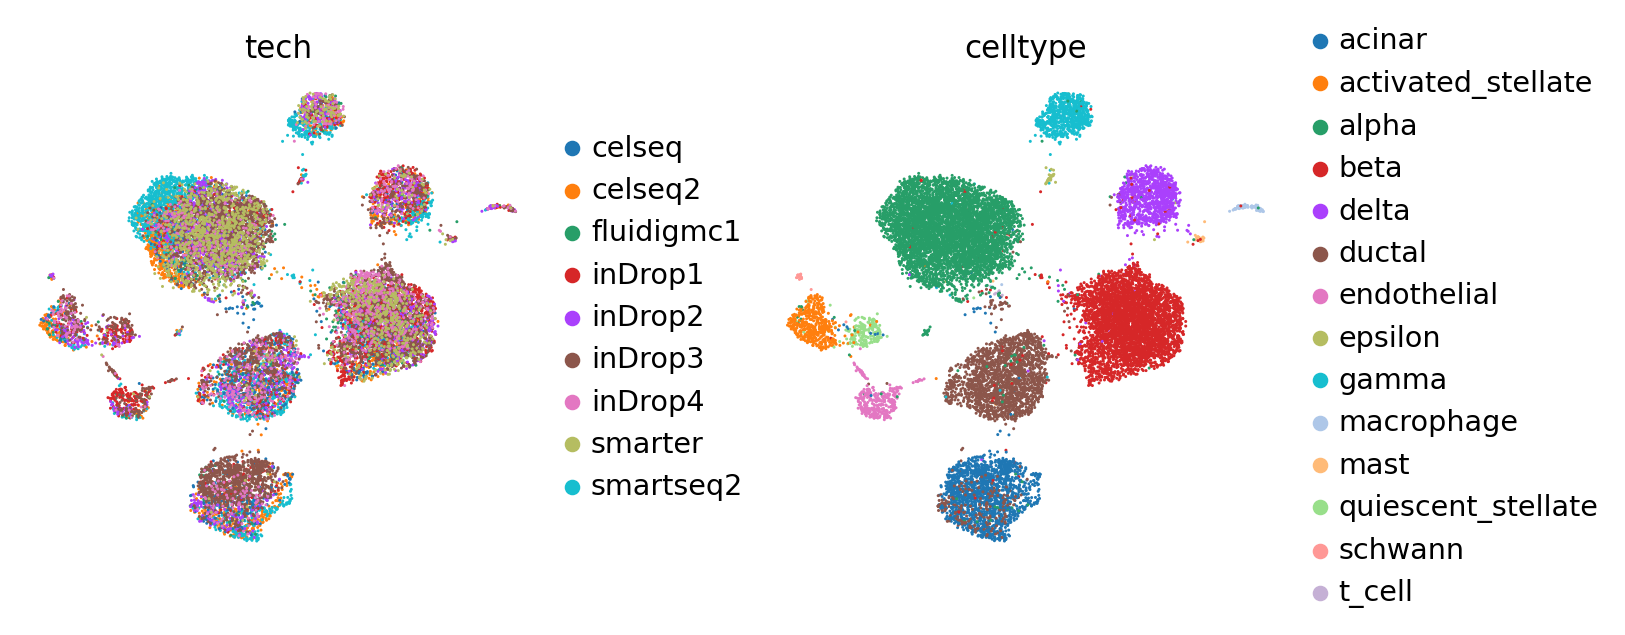

In [22]:
sc.pl.umap(
    adata_full,
    color=["tech", "celltype"],
    wspace = 0.3,
    frameon=False,
    ncols=2,
    save = '_pancreas_surgery.png'
)

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


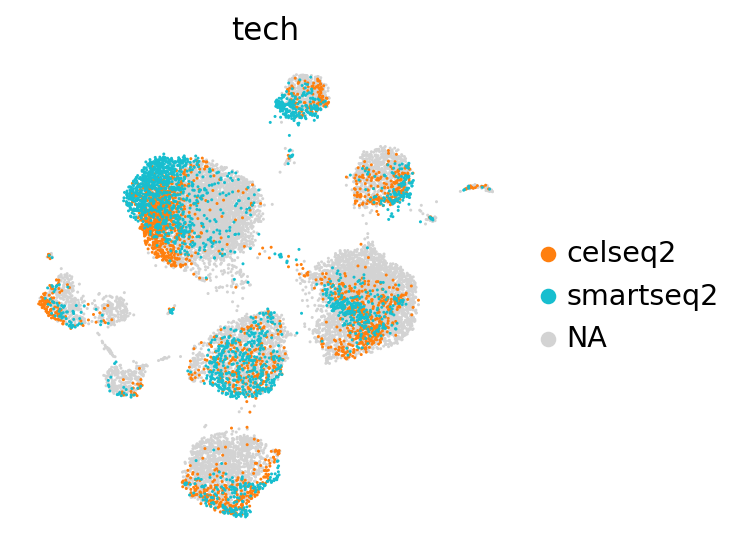

In [23]:
sc.pl.umap(
    adata_full,
    color=["tech"],
    groups = ['celseq2','smartseq2'],
    frameon=False,
    ncols=2,
)

In [24]:
techs = adata_full.obs.tech.cat.categories.tolist()
techs = [x for x in techs if x not in ['celseq2','smartseq2']]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


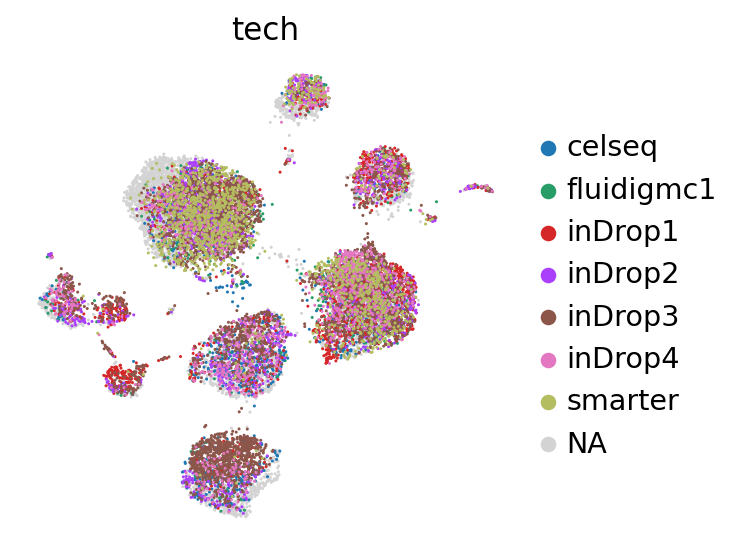

In [25]:
sc.pl.umap(
    adata_full,
    color=["tech"],
    groups = techs,
    frameon=False,
    ncols=2,
)

In [26]:
adata_full.write('../results/pancreas_surgery_latent.h5ad')